In [63]:
# Elaborado por:
# Ana Mantilla : anagmd2019@gmail.com
# Paul Goyes : goyes.yesid@gmail.com

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import random
random.seed(4321)

In [66]:
# Importar las librerías

import pandas as pd #usada para cargar los datos delimitados por comas (.csv)
import numpy as np #usada para extraer los valores de píxel del ráster en una matriz
import matplotlib.pyplot as plt #usada para gráficar
import tensorflow as tf #usada para crear el modelo de redes neuronales artificiales
from tensorflow import keras
from tensorflow.keras.models import Model

In [67]:
# Cargar el modelo preentrenado

model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/PAPER_DL/MODELOS-PRE-ENTRENADOS/modelo_pretext.h5")

In [68]:
# Imprimir resumen de la arquitectura del modelo

#model.summary()

In [69]:
# Crea un nuevo modelo que incluya solo las capas específicas

clasifier = Model(inputs=model.input, outputs=model.layers[4].output)

# Congelar todas las capas del modelo encoder pre-entrenado
for layer in clasifier.layers:
    layer.trainable = False

In [70]:
#clasifier.summary()

In [71]:
# Cargar datos de entrenamiento

df_yukon=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PAPER_DL/TRAINING/02_Train_PCA.csv', sep=',')

In [72]:
# Extraer variables de entrada y de salida

y_names_yukon=['DEP'] # Valores de salida-etiquetas de depósito (1) y no depósito (0)
y_yukon=df_yukon[y_names_yukon].values

x_names_yukon=['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
X_yukon=df_yukon[x_names_yukon].values

In [73]:
# Calcular peso de cada clase y el bias inicial

pos = len(y_yukon[y_yukon==1])
neg = len(y_yukon[y_yukon==0])
total= pos+neg
print('pos: ', pos)
print('neg:' , neg)

weight_for_0 = (1 / neg) * (total/2 )
weight_for_1 = (1 / pos) * (total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

initial_bias = np.log(pos/neg)
print(initial_bias)
output_bias = tf.keras.initializers.Constant(initial_bias)

pos:  95
neg: 218
-0.8306181711885482


In [74]:
# Añadir capa de salida

latent = tf.keras.layers.Dense(1, activation="sigmoid", bias_initializer=None, name="Deposito", kernel_regularizer='l1_l2')(clasifier.layers[-1].output)
model_classifier = Model(inputs=clasifier.input, outputs=latent)

In [75]:
#model_classifier.summary()

In [76]:
# Imprimir un diagrama de grafo del modelo

#tf.keras.utils.plot_model(model_classifier, show_shapes=True)

In [77]:
# Indicar el optimizador usado para el backpropagation y las métricas de evaluación

optimizer    = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn      =  tf.keras.losses.BinaryCrossentropy() # tambien se puede indicar la función de perdida como las predeterminadas en keras

In [78]:
# Compilar el modelo con los hiperparámetros que se definieron anteriormente

model_classifier.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Transferencia de aprendizaje. Entrenar el modelo clasificador

history= model_classifier.fit(
    x=X_yukon,
    y=y_yukon,
    batch_size=82,
    epochs=5000,
    )

Streaming output truncated to the last 5000 lines.
Epoch 3501/6000
4/4 [==============================] - 0s 6ms/step - loss: 2.1188 - accuracy: 0.6102
Epoch 3502/6000
4/4 [==============================] - 0s 7ms/step - loss: 2.1186 - accuracy: 0.6102
Epoch 3503/6000
4/4 [==============================] - 0s 6ms/step - loss: 2.1184 - accuracy: 0.6102
Epoch 3504/6000
4/4 [==============================] - 0s 8ms/step - loss: 2.1183 - accuracy: 0.6102
Epoch 3505/6000
4/4 [==============================] - 0s 7ms/step - loss: 2.1181 - accuracy: 0.6102
Epoch 3506/6000
4/4 [==============================] - 0s 6ms/step - loss: 2.1180 - accuracy: 0.6102
Epoch 3507/6000
4/4 [==============================] - 0s 8ms/step - loss: 2.1178 - accuracy: 0.6102
Epoch 3508/6000
4/4 [==============================] - 0s 9ms/step - loss: 2.1176 - accuracy: 0.6102
Epoch 3509/6000
4/4 [==============================] - 0s 8ms/step - loss: 2.1175 - accuracy: 0.6102
Epoch 3510/6000
4/4 [===================

In [ ]:
# En la variable "history" quedan guardadas todas las métricas y funciones de perdida evaluadas en cada época.
# Podemos hacer una gráfica para cada una de ellas, primero vemos lo que podemos gráficar:


print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [ ]:
# Guardar las métricas del modelo en formato .npz

np.savez('/content/drive/MyDrive/Colab Notebooks/PAPER_DL/METRICAS-MODELOS/GPC_LP.npz', loss=history.history['loss'], acc=history.history['accuracy'])

In [ ]:
# Calcular la precisión y valor de la función de pérdida del entrenamiento

score= model_classifier.evaluate(X_yukon,y_yukon)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 5ms/step - loss: 1.7262 - accuracy: 0.5815
Test loss: 1.7262094020843506
Test accuracy: 0.5814696550369263


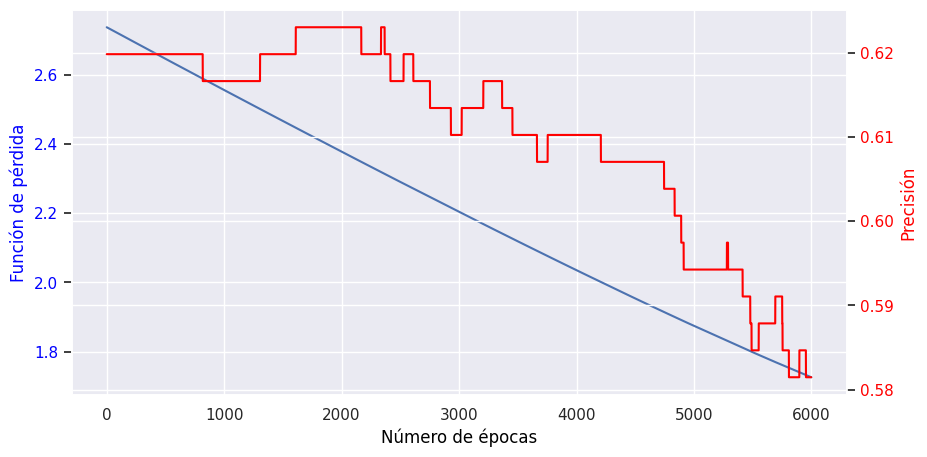

In [ ]:
# Graficar las métricas

fig, ax1 = plt.subplots(1,1,figsize=(10,5))
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(history.history['loss'],'b',label='LOSS')
ax1.set_ylabel('Función de pérdida', color='blue')
ax1.set_xlabel('Número de épocas', color='black')
ax2 = ax1.twinx()
ax2.set_ylabel('Precisión', color='red')
ax2.plot(history.history['accuracy'],'red')
ax2.tick_params(axis='y', labelcolor='red')

In [ ]:
# Predecir los datos

pred_val = model_classifier.predict(X_yukon)

10/10 [==============================] - 0s 2ms/step


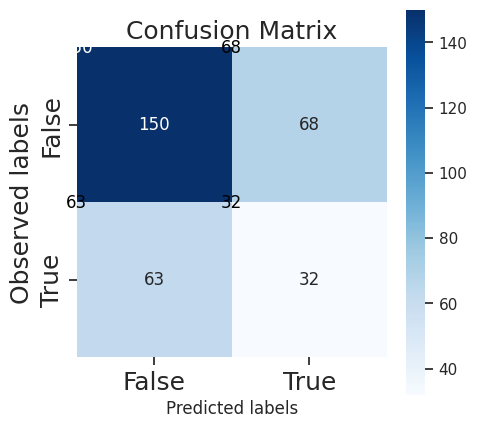

In [ ]:
# Matriz de confusión

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

matriz3 = confusion_matrix(y_yukon, np.around(pred_val))
plot_confusion_matrix(conf_mat = matriz3, figsize = (5,5))

ax = plt.subplot()
sns.set(font_scale=1) # Adjust to fit
sns.heatmap(matriz3, annot=True, ax=ax, cmap="Blues", fmt="g");

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels');
ax.set_ylabel('Observed labels',fontdict=label_font);

title_font = {'size':'18'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=18)  # Adjust to fit
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);

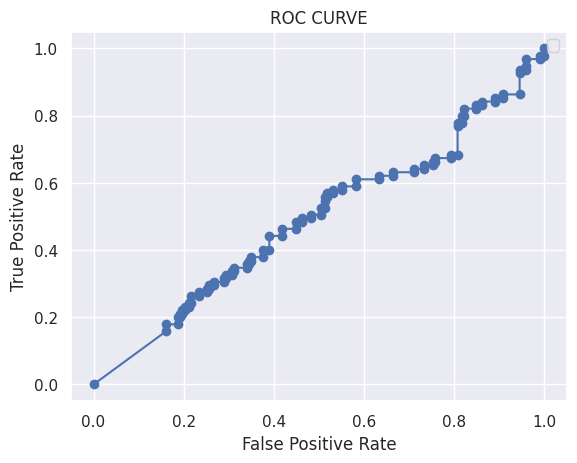

In [ ]:
# Cálculo del AUC y ROC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

fpr_, tpr_, thresholds_ = roc_curve(y_yukon, pred_val)

plt.plot(fpr_, tpr_, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC CURVE')
plt.grid(True)

In [ ]:
# Cálculo del AUC

from sklearn import metrics

print(f'El AUC para el modelo de bosques aleatorios es de: {metrics.auc(fpr_, tpr_)}')

El AUC para el modelo de bosques aleatorios es de: 0.49196040560115883


In [ ]:
# Guardar el modelo entrenado

model_classifier.save('/content/drive/MyDrive/Colab Notebooks/PAPER_DL/MODELOS-FINALES/pretext_linear.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Cargar el virtual ráster que se descarga desde el link del repositorio

from osgeo import gdal

raster  = gdal.Open('/content/drive/MyDrive/Colab Notebooks/PAPER_DL/VIRTUAL_RASTER/02_PCA.tif')  # Esta ruta cambia según dónde se guardó el archivo del virtual ráster

In [ ]:
# Extraer las características del ráster

driver = raster.GetDriver()
col   = raster.RasterXSize #número de columnas
rows  = raster.RasterYSize #número de filas
nelem = col*rows #número de píxeles

print('numero de filas: ', rows)
print('numero de columnas: ', col)

# Guardar las posiciones NonData del ráster. Solo se hace una vez para cualquier banda
# ya que las posiciones de Nonvalue deben ser las mismas para todas las bandas


Nonvalue = raster.GetRasterBand(1).GetNoDataValue()

print(Nonvalue)

#Extraer los valores de cada banda

v1val = raster.GetRasterBand(1).ReadAsArray().flatten()
v2val = raster.GetRasterBand(2).ReadAsArray().flatten()
v3val = raster.GetRasterBand(3).ReadAsArray().flatten()
v4val = raster.GetRasterBand(4).ReadAsArray().flatten()
v5val = raster.GetRasterBand(5).ReadAsArray().flatten()
v6val = raster.GetRasterBand(6).ReadAsArray().flatten()
v7val = raster.GetRasterBand(7).ReadAsArray().flatten()

# Agrupar los valores tal que se forme una matriz de N X 9
# donde N es el número de muestras

DATA = np.stack((v1val,v2val,v3val,v4val,v5val,v6val,v7val),axis=1)


# Organizar los datos y eliminar las posiciones de NonData

NanValues = np.where(v1val == Nonvalue)[0]
cP        = np.arange(0,nelem)
cPP       = np.delete(cP, NanValues, axis=0)

XX = np.delete(DATA, NanValues, axis=0)

numero de filas:  110
numero de columnas:  118
-9999.0


In [ ]:
# Predecir los valores con el modelo entrenado

y_raster = model_classifier.predict(XX)

406/406 [==============================] - 1s 2ms/step


In [ ]:
# Crear nuevamente el formato de datos para llevarlo al raster.
# Usaremos una variable nueva llena de zeros, en la cual insertaremos los NonValues y los valores de la predicción.
# el tamaño de esta variable será el mismo que el raster

Rasterdataarray = np.zeros((rows,col)).flatten()

# cPP contiene las posiciones donde van las predicciones
for i in range(cPP.shape[0]):
    Rasterdataarray[cPP[i]]=y_raster[i]

# NanValues contiene las posiciones donde van los NOnValues
for i in range(NanValues.shape[0]):
    Rasterdataarray[NanValues[i]]=Nonvalue


# guardar la predicción en un raster con las mismas caracteristicas del raster input

Rasterout = driver.Create('/content/drive/MyDrive/Colab Notebooks/PAPER_DL/MAPA_PROBABILIDAD/04_Pretext_Linear_Probing.tif', col, rows, 1, gdal.GDT_Float32) #esta ruta se modifica según donde desee que se guarde el mapa de probabilidad en su Google Drive
# Write metadata
Rasterout.SetGeoTransform(raster.GetGeoTransform())
Rasterout.SetProjection(raster.GetProjection())

Rasterout.GetRasterBand(1).WriteArray(Rasterdataarray.reshape(rows,col))
Rasterout.GetRasterBand(1).SetNoDataValue(Nonvalue)
Rasterout = None
del Rasterout

<ipython-input-123-aea4d512365c>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Rasterdataarray[cPP[i]]=y_raster[i]


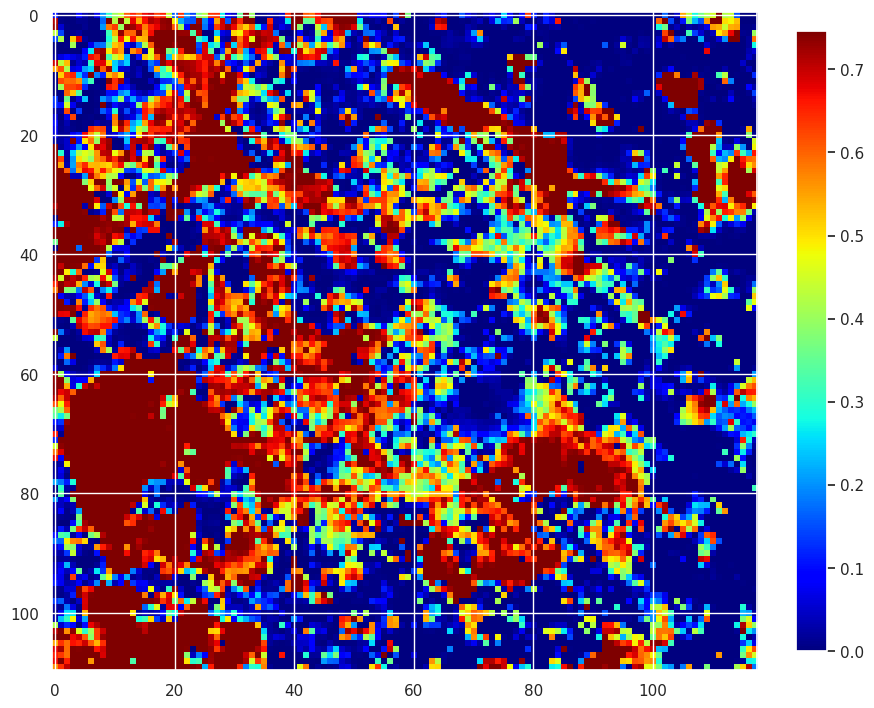

In [ ]:
# Visualizar el mapa de probabilidad

mask = Rasterdataarray!=-9999
v2 = Rasterdataarray[np.where(mask)]
v2 = v2.reshape(-1,118)
plt.figure(figsize=(10,10))
plt.imshow(v2,cmap='jet')
plt.colorbar(fraction=0.04)

# **Créditos**
---

* **Autores:**
  * [Ana Gabriela Mantilla, Geóloga](https://www.linkedin.com/in/ana-gabriela-mantilla-24377a21a)
  * [Paul Goyes Peñafiel, PhD (c)](https://www.linkedin.com/in/paul-goyes-0212b810/)